In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from fem2D import Node, Element, plotMesh, readGmsh4, eraseCurrentMesh
from squareMesh import squareMesh

In [15]:
# definition du maillage à la main

eraseCurrentMesh()

N = 40
L = 100.0
dx = L/N

# xCoords = np.linspace(0.0, L, N+1)
# dof = (N+1)*(N+1)
# omega = 1

# Node.id = 0
# nodesCoord = np.array([[[x,y] for x in xCoords] for y in xCoords]).reshape((dof,2))
# nodes = [Node(coord[0], coord[1], omega) for coord in nodesCoord]

# Element.id = 0
# elements = []
# for i in range(N*N):
#     nodesIdx = [i+i//N,i+1+i//N,i+N+2+i//N,i+N+1+i//N]
#     elements.append(Element([nodes[n] for n in nodesIdx]))

elements, nodes = squareMesh(L,dx)

dof = len(nodes)
print(f"{dof=}")

dof=1681


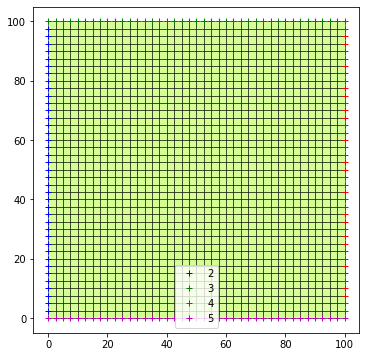

In [16]:
plotMesh(elements, nodes ,[2,3,4,5])

In [17]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles
phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradPhi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [18]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)

In [19]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 5 

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [20]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((4,4))
    e.Me = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):

            fk = lambda u,v: (e.iJ(u,v)@gradPhi[i](u,v))@(e.iJ(u,v)@gradPhi[j](u,v))*e.detJ(u,v)
            e.Ke[i,j] = int2D(fk)

            fm = lambda u,v: phi[i](u,v)*phi[j](u,v)*e.detJ(u,v)
            e.Me[i,j] = int2D(fm)

100%|██████████| 1600/1600 [00:52<00:00, 30.21it/s]


In [56]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((dof,dof))
M = np.zeros((dof,dof))
F = np.zeros(dof)

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]
            M[n1.id,n2.id] += e.Me[i,j]

In [57]:
# Conditions aux limites : point source (CL sur le déplacement)

noeudSource = int(dof/4)

In [58]:
# inverting mass matrix

iM = np.linalg.inv(M)

In [59]:
# résolution temporelle

Nit = 3000
cfl = 0.1
Δx = L/N
Δt = Δx* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, dof))
dU = np.zeros((Nit, dof))
ddU = np.zeros((Nit, dof))

# définition source

t0 = T/8.0         # tuning
f0 = 1/(16*Δx)     # tuning
f = lambda t : (4*(t-t0)**2*f0**4 - 2*f0**2)*np.exp(-(t-t0)**2*f0**2)

In [60]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx}")
print(f"Δx = {Δx}m while λmin ~ {1/(4*f0)}")

CFL = 0.1
Δx = 2.5m while λmin ~ 10.0


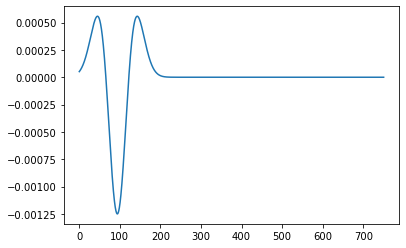

In [61]:
plt.plot(time, f(time))

In [62]:
# FD
for i in tqdm(range(2,Nit)):
    F[noeudSource] = f(i*Δt)
    U[i,:] = 2*U[i-1,:] - U[i-2,:] + Δt**2*iM @ (F - K@U[i-1,:])

100%|██████████| 2998/2998 [00:16<00:00, 176.89it/s]


In [41]:
# Newmark

# for i in tqdm(range(1,Nit)):
#     F[noeudSource] = f(i*Δt)
#     U[i,:] = U[i-1,:] + Δt*dU[i-1,:] + (Δt**2 /2)*ddU[i-1,:]
#     ddU[i,:] = iM @ (F - K@U[i,:])
#     dU[i,:] = dU[i-1,:] + (Δt/2)*(ddU[i-1,:] + ddU[i,:])

100%|██████████| 2999/2999 [00:08<00:00, 366.15it/s]


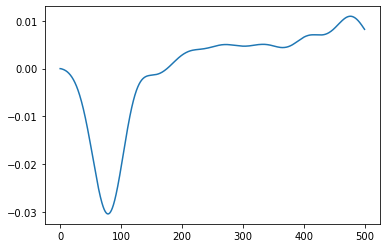

In [65]:
lim = 2000

plt.plot(time[:lim], U[:lim,noeudSource])


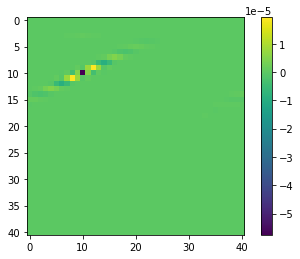

In [68]:
idx = 10
plt.imshow(U[idx,:].reshape((N+1,N+1)))
plt.colorbar()

In [71]:
import matplotlib.animation as animation

In [74]:
# animation

%matplotlib tk

fig, ax = plt.subplots()

umax = max(U.max(), -U.min())

im = ax.imshow(U[0,:].reshape((N+1,N+1)), vmin=-umax, vmax=umax, cmap="seismic")
cbar = plt.colorbar(im)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)


dit = 10

def updatefig(i): 
    im.set_data(U[i*dit,:].reshape((N+1,N+1)))
    ttl.set_text(f"it = {dit*i}")
    return im,ttl,
    
anim = animation.FuncAnimation(fig, updatefig, interval=300, frames=int(Nit/dit))
anim.event_source.start()
plt.show()